Using device: cpu


/home/xqgao/2025/MIT/Awesome-Computational-Imaging/chapters/Chapter12_PlugAndPlay/dppp.py:333: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load

Iterative


HQS steps:   8%|▊         | 5/60 [00:02<00:29,  1.84it/s]

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
PSNR: 28.31, LPIPS: 0.2103


/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map

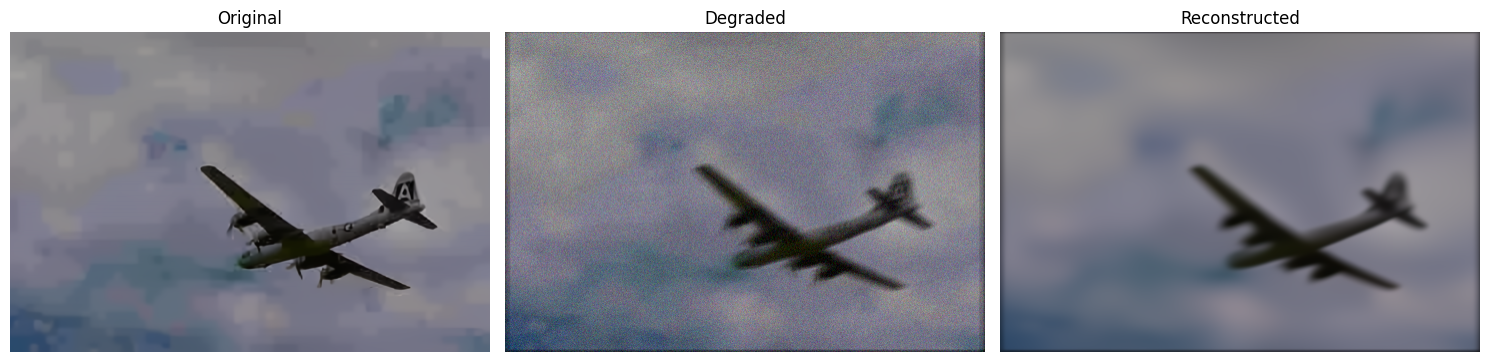

HQS steps:  18%|█▊        | 11/60 [00:06<00:28,  1.71it/s]

PSNR: 28.37, LPIPS: 0.2046


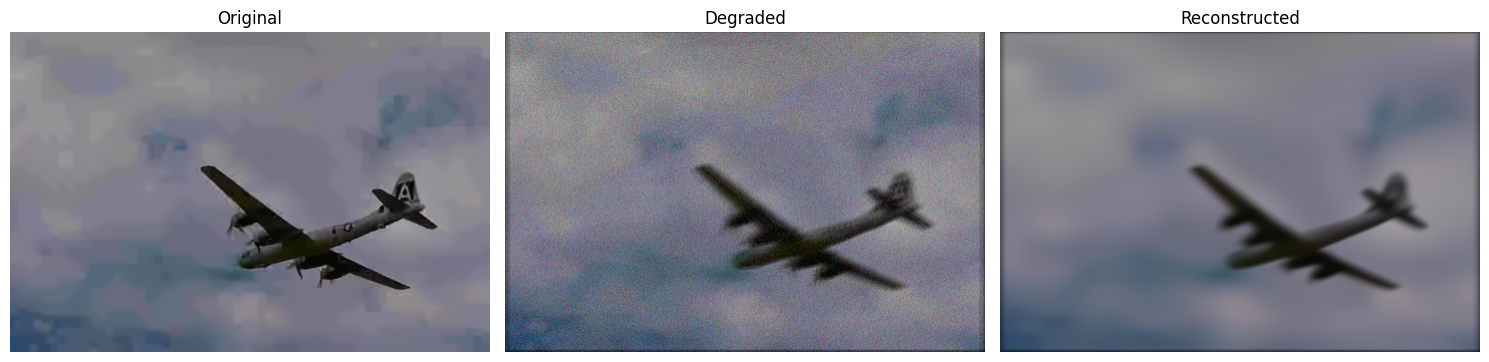

HQS steps:  28%|██▊       | 17/60 [00:10<00:24,  1.73it/s]

PSNR: 28.43, LPIPS: 0.1986


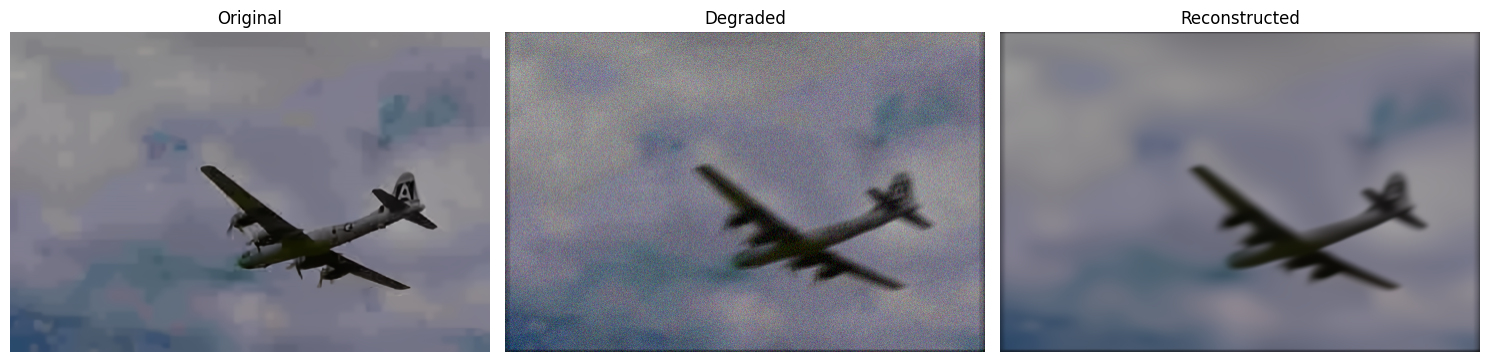

HQS steps:  38%|███▊      | 23/60 [00:13<00:21,  1.71it/s]

PSNR: 28.49, LPIPS: 0.1926


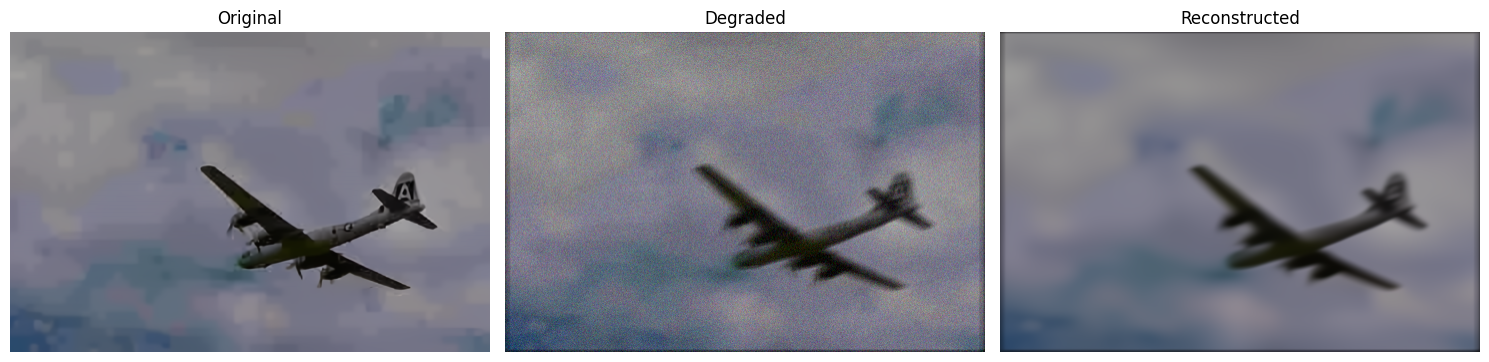

HQS steps:  48%|████▊     | 29/60 [00:17<00:16,  1.83it/s]

PSNR: 28.53, LPIPS: 0.1871


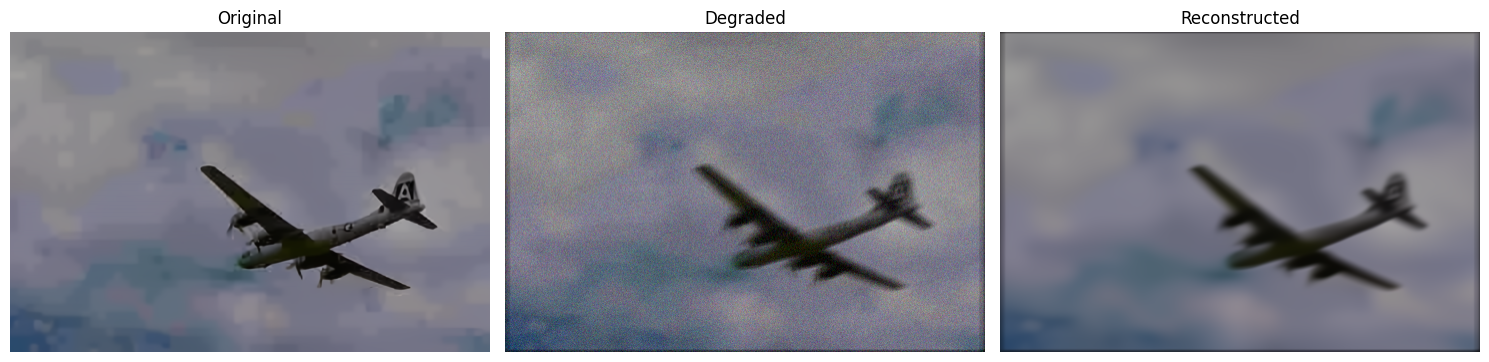

HQS steps:  58%|█████▊    | 35/60 [00:21<00:14,  1.75it/s]

PSNR: 28.57, LPIPS: 0.1815


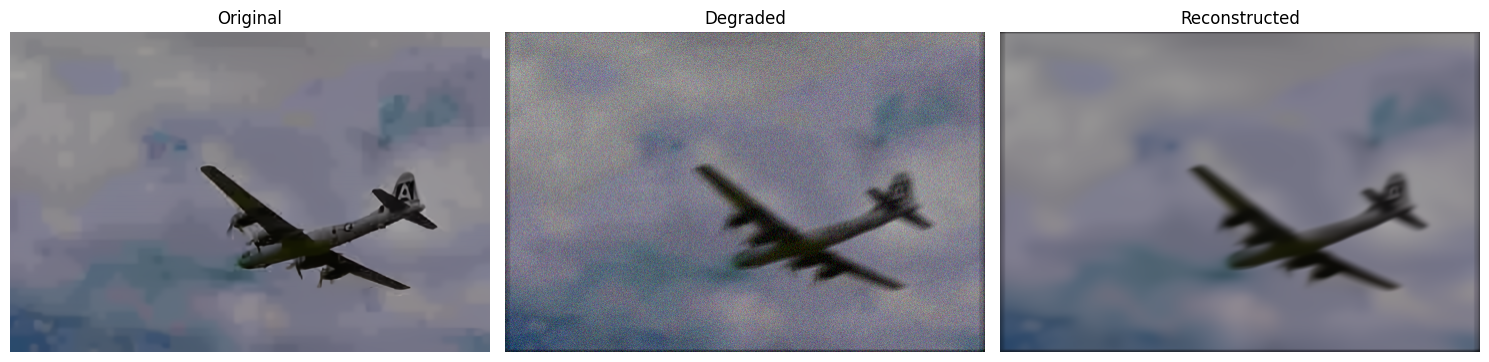

HQS steps:  68%|██████▊   | 41/60 [00:24<00:10,  1.82it/s]

PSNR: 28.60, LPIPS: 0.1760


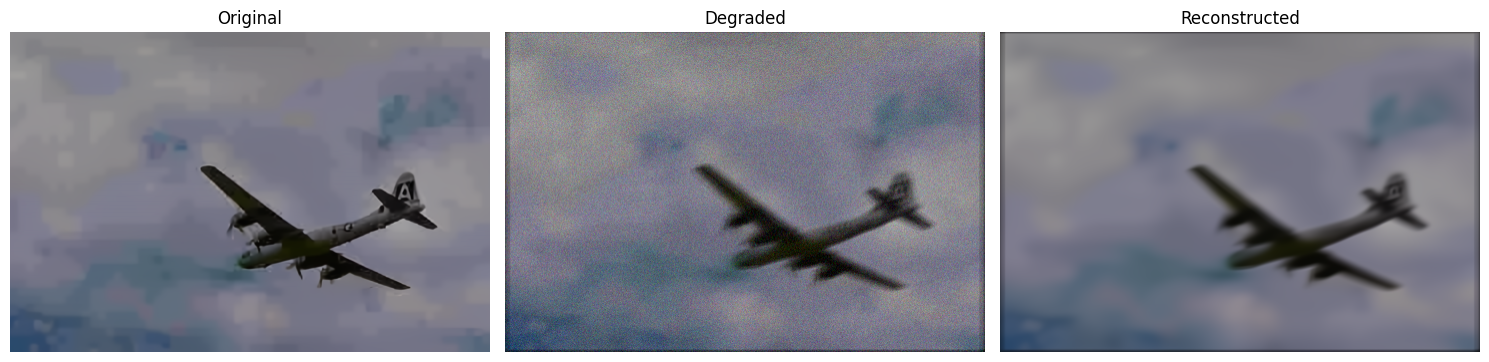

HQS steps:  78%|███████▊  | 47/60 [00:27<00:06,  1.88it/s]

PSNR: 28.63, LPIPS: 0.1702


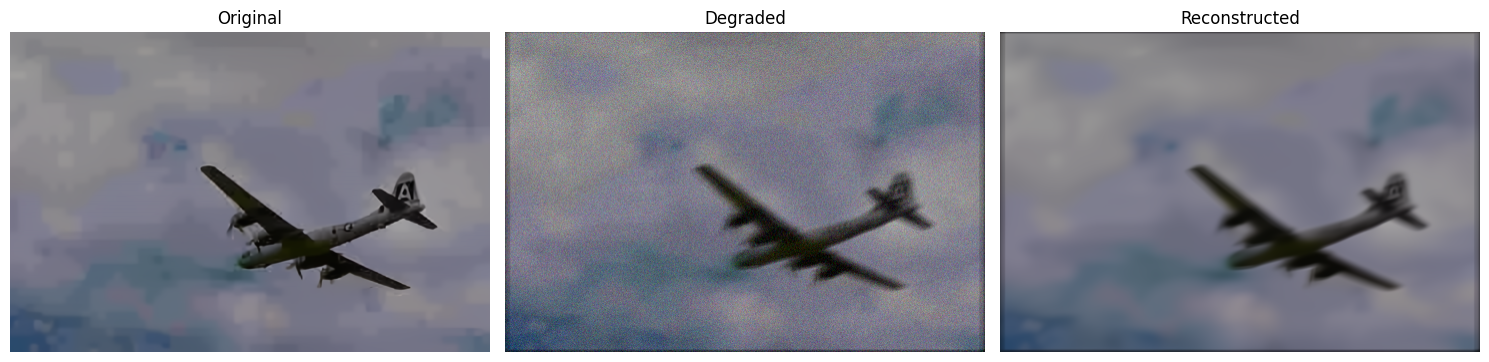

HQS steps:  88%|████████▊ | 53/60 [00:31<00:03,  1.83it/s]

PSNR: 28.65, LPIPS: 0.1624


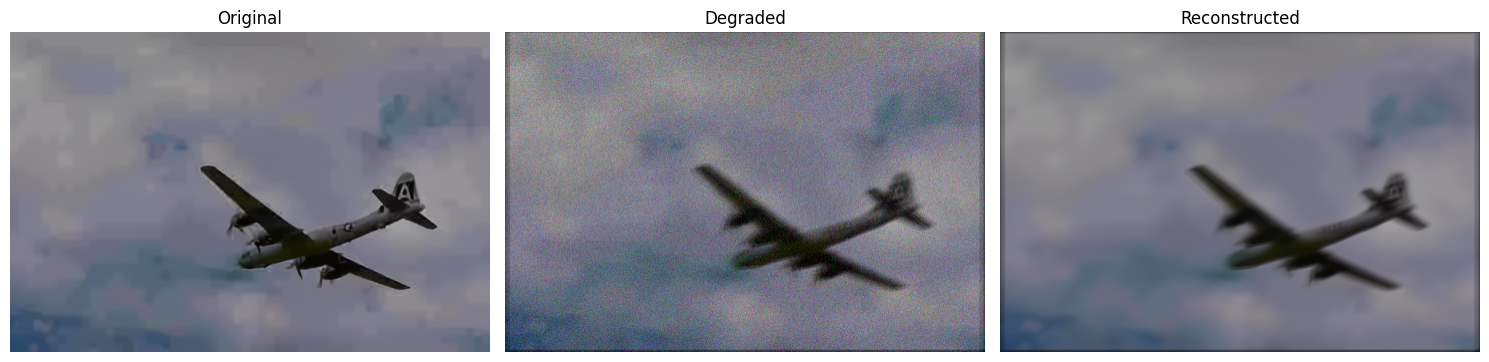

HQS steps:  98%|█████████▊| 59/60 [00:34<00:00,  1.89it/s]

PSNR: 28.64, LPIPS: 0.1533


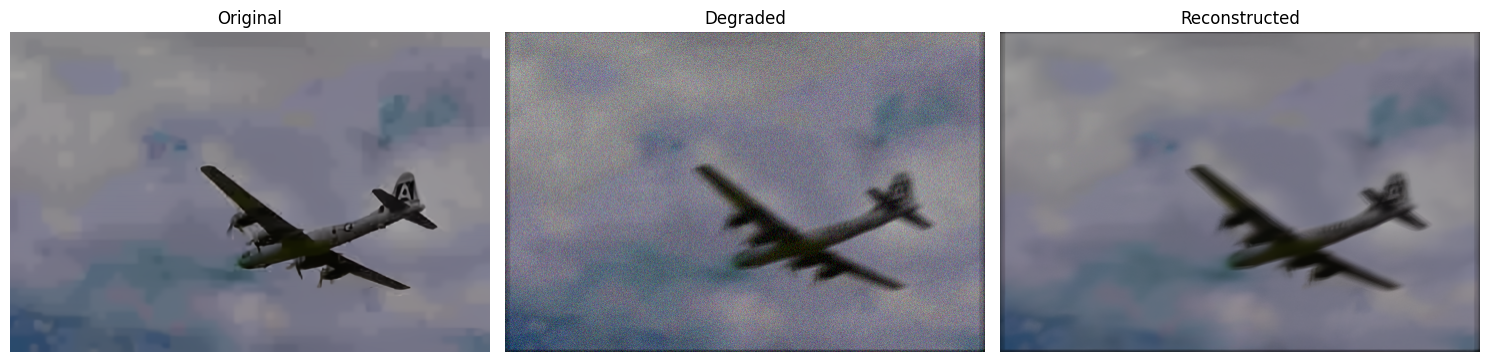

HQS steps: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import dppp  # 你写好的模块（含 blur, psnr, lpips_alex, hqs_super_resolve 等）
import matplotlib.pyplot as plt

# ✅ 自动设置设备
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device='cpu'
print("Using device:", device)

# ✅ Dataset 加载图像
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir):
        self.image_paths = sorted([
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
        ])
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img)

# ✅ 智能 imshow 函数
def smart_imshow(tensor, title=None):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu()
    if tensor.dim() == 3:
        if tensor.shape[0] in [1, 3]:  # [C, H, W]
            tensor = tensor.permute(1, 2, 0).numpy()
        else:  # [H, W, C]
            tensor = tensor.numpy()
    elif tensor.dim() == 2:
        tensor = tensor.numpy()
    if tensor.ndim == 2 or (tensor.ndim == 3 and tensor.shape[2] == 1):
        plt.imshow(tensor.squeeze(), cmap='gray')
    else:
        plt.imshow(tensor)
    if title:
        plt.title(title)
    plt.axis("off")

# ✅ 数据路径
data_root = "/home/xqgao/2025/MIT/Datasets/CBSD68/original"
dataset = ImageFolderDataset(data_root)

# ✅ 选一张图并送到 GPU
image = dataset[0].unsqueeze(0).to(device)  # [1, 3, H, W]

# ✅ 准备模糊核
kernel = dppp.conv2D_filter_rgb(dppp.NB_DEBLURRING_LEVIN_KERNELS[0]).to(torch.float32).to(device)

# ✅ 模拟退化图像
noise_stddev = 0.04
degraded = dppp.blur(image, kernel, noise_stddev=noise_stddev)

# ✅ 加载去噪器（确保内部模型也转 device）
denoiser = dppp.load_denoiser(device=device)

# ✅ 去卷积重建
reconstructed = dppp.hqs_super_resolve(
    degraded=degraded,
    image=image,
    sr_factor=1,
    denoiser=denoiser,
    max_denoiser_stddev=0.2,
    kernel=None,
    noise_stddev=noise_stddev,
    callbacks=[],
)

